In [8]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [9]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


<IPython.core.display.Javascript object>


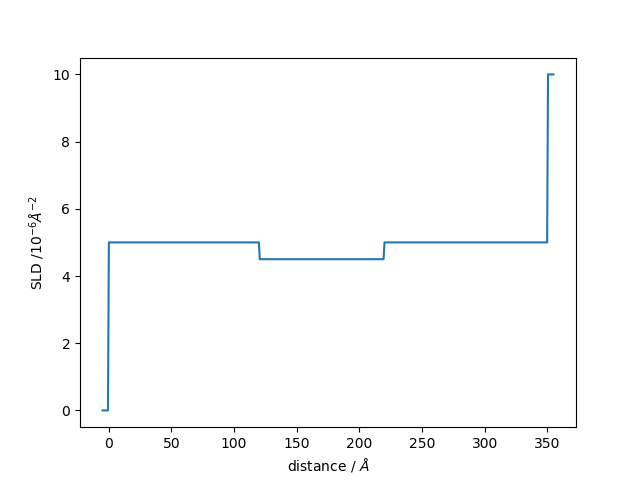

done


In [10]:
%matplotlib notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [11]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

In [ ]:
q = np.linspace(0.005, 0.3, 1001)
losses = [0.5,0.75,0.9,1]
R = model(q, x_err=resolution)
datas = []
objectives = []
results = []
lnPosts = []
structures = []
for loss in losses:
    sim_dR = msd.main(sim_q=q,sim_R=R*loss)*10
    data = Data1D(data=(q,R,sim_dR))
    datas.append(data)
    for i in range(1,5):
        objective = gO(data, i)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
        DNSampler.run_nested(dlogz_init=50)#0.01)
        result = DNSampler.results
        objectives.append(objective)
        structures.append(structure.sld_profile())
        
